In [1]:
import holidays
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

warnings.filterwarnings('ignore')

### Data preparation

In [2]:
df = pd.read_csv('data/covid19-clean.csv')
df['Date'] = df['Date'].apply(lambda row: datetime.strptime(row, "%d %B %Y "))

In [3]:
data = df[['Date', 'Recovered']]
data.columns = ['ds', 'y']

In [4]:
holidays_pl = pd.DataFrame(holidays.PL(years = 2020), index = [0]).T.reset_index()
holidays_pl.columns = ['ds', 'holiday']
holidays_pl['lower_window'] = -1
holidays_pl['upper_window'] = 3

# Modeling

### Model creation

In [5]:
model_args = {
    'seasonality_mode': 'additive',
    'changepoint_prior_scale': 0.05,
    'seasonality_prior_scale': 0.05,
    'holidays_prior_scale': 0.01,
    'weekly_seasonality': 8,
    'yearly_seasonality': False,
    'daily_seasonality': False,
    'changepoint_range': 0.8,
    'holidays': holidays_pl,
    'mcmc_samples': 1000
}

In [6]:
model = Prophet(**model_args)
model.add_seasonality(name = '2-weekly', period = 14, fourier_order = 8, prior_scale = 0.05)
model.fit(data[40:])

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [7]:
future = model.make_future_dataframe(periods = 1)
forecast = model.predict(future)

In [8]:
forecast = pd.merge(forecast, model.history[['ds', 'y']], on='ds')
forecast[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,y,yhat,yhat_lower,yhat_upper
66,2020-06-12,109.0,230.012219,123.573753,330.671926
67,2020-06-13,299.0,310.208819,205.637455,409.205602
68,2020-06-14,122.0,241.052971,134.297336,345.010977
69,2020-06-15,157.0,216.593178,112.755966,319.477840
70,2020-06-16,271.0,281.371031,176.426387,381.792447
71,2020-06-17,267.0,321.072253,220.536208,429.260706
72,2020-06-18,396.0,305.468029,198.486918,402.431003
73,2020-06-19,381.0,308.019683,210.050168,409.609497
74,2020-06-20,483.0,316.414334,213.894075,418.117241
75,2020-06-21,502.0,305.161840,202.861138,404.436231


### Model explanation

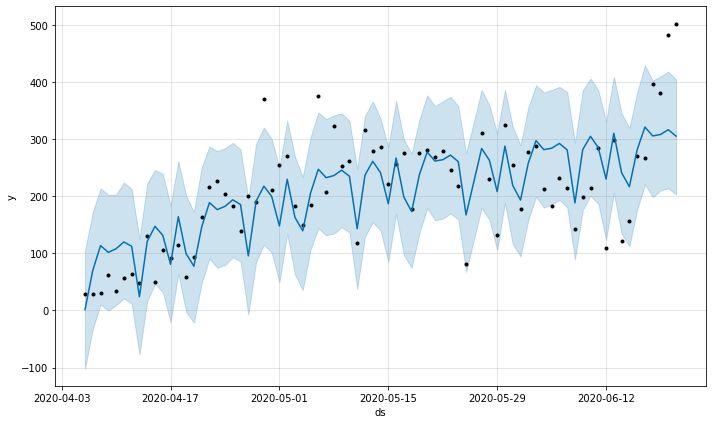

In [9]:
fig = model.plot(forecast)

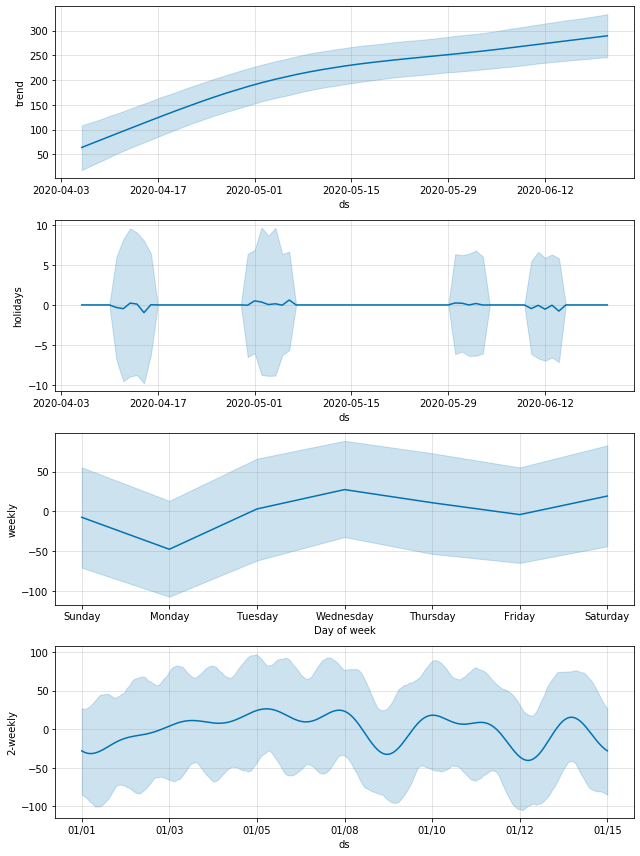

In [10]:
fig = model.plot_components(forecast, uncertainty=True)

### Model performance

In [11]:
results = cross_validation(model, initial = '69 days', horizon = '1 day', period = '1 day')
metrics = performance_metrics(results)

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-06-14 00:00:00 and 2020-06-20 00:00:00


In [12]:
results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-06-15,171.573570,92.948043,254.046270,157.0,2020-06-14
1,2020-06-16,224.929539,147.159173,305.583459,271.0,2020-06-15
2,2020-06-17,273.795813,196.929444,350.889441,267.0,2020-06-16
3,2020-06-18,230.948867,150.661377,305.618001,396.0,2020-06-17
4,2020-06-19,248.778348,169.932946,331.969187,381.0,2020-06-18
5,2020-06-20,253.352500,168.425546,341.107333,483.0,2020-06-19
6,2020-06-21,250.214983,154.217838,346.735963,502.0,2020-06-20


In [13]:
metrics

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,23319.881463,152.708485,120.877878,0.289877,0.347038,0.428571


### Tomorrow prediction

In [14]:
np.round(forecast.iloc[-1]['yhat']).astype(int)

305